In [1]:
import pandas as pd
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import math

 # TZ metrics

## Static route stretch

In [2]:
def import_stretch(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"], usecols=[0,1,2])
    return df

In [47]:
def crunch_stretch(filename):
    pandas_data = import_stretch(filename)
    static_stretch = pandas_data.to_numpy()
    
    # Filter out paths with same origin and destination
    static_stretch = static_stretch[static_stretch[:,0] > 0,:]
    
    plt.scatter(static_stretch[:,0], static_stretch[:,1], alpha=.3)
    plt.plot([1, 14], [1, 14], color="green")
    plt.title("Path lenghts combinations")
    
    stretches = static_stretch[:,1].astype(float) / static_stretch[:,0] 
    stretch_distr = np.sort(stretches)
    
    print("Measured average stretch: %f\tMeasured median stretch: %f\t Paths with valleys: %f\n" % (np.average(stretches), np.median(stretches), np.average(static_stretch[:,2])))
    
    stretch_distr = np.array([[x[0], x.shape[0]] for x in np.split(stretch_distr, np.unique(stretch_distr, return_index=True)[1])[1:]])
    stretch_distr[:,1] = stretch_distr[:,1] / float(static_stretch.shape[0])
    
    plt.figure()
    plt.xlabel("TZ stretch")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(stretch_distr[:,0], stretch_distr[:,1], '--o', alpha=.7, label="Stretch PDF")
    plt.plot(stretch_distr[:,0], np.cumsum(stretch_distr[:,1]), ':^', label="Stretch CDF")
    #plt.vlines(1.1, ymin=0, ymax=1, linestyles='dashed', colors=['green'])
    plt.legend()

Measured average stretch: 1.054610	Measured median stretch: 1.000000	 Paths with valleys: 0.010106



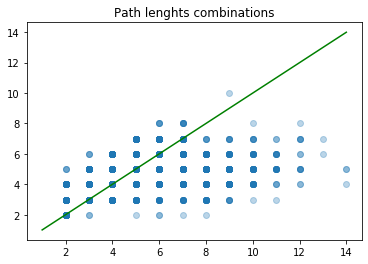

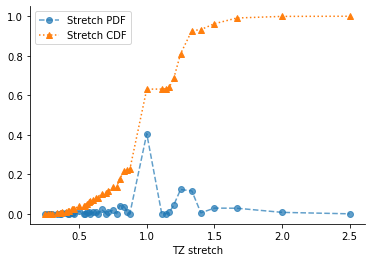

In [48]:
crunch_stretch("./simulation/data/full-stretch-GRP-4000.csv")

Measured average stretch: 1.101602	Measured median stretch: 1.000000	 Paths with valleys: 0.045827



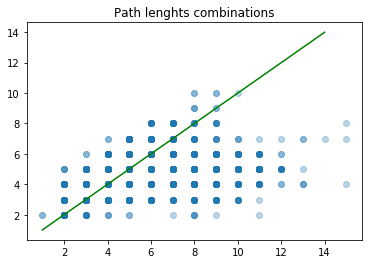

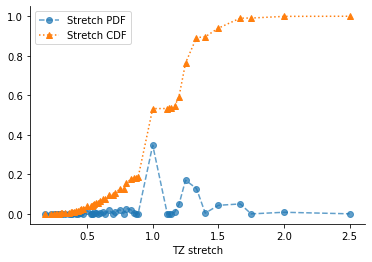

In [49]:
crunch_stretch("./simulation/data/full-stretch-GR-6000.csv")

Measured average stretch: 1.100412	Measured median stretch: 1.000000	 Paths with valleys: 0.015049



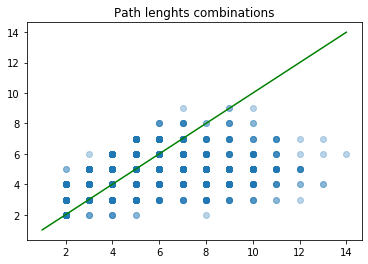

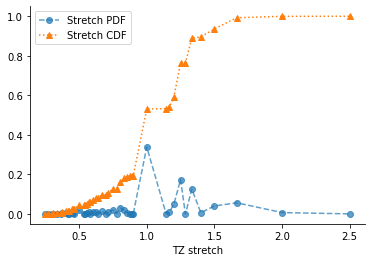

In [50]:
crunch_stretch("./simulation/data/full-GR-stretch-4000.csv")

Measured average stretch: 1.117611	Measured median stretch: 1.000000	 Paths with valleys: 0.150189



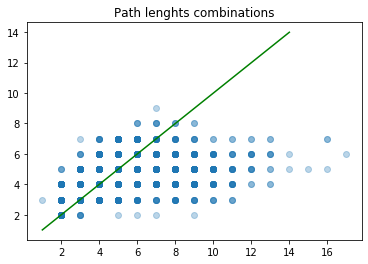

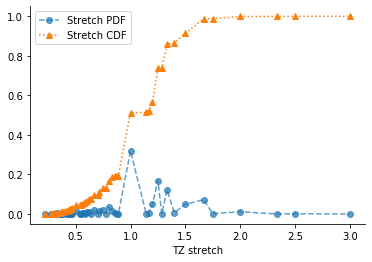

In [51]:
crunch_stretch("./simulation/data/full-GR(not-on-discovery)-stretch-4000.csv")

Measured average stretch: 1.105795	Measured median stretch: 1.000000	 Paths with valleys: 0.115520



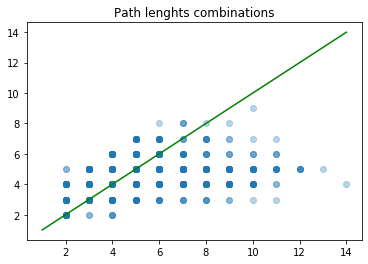

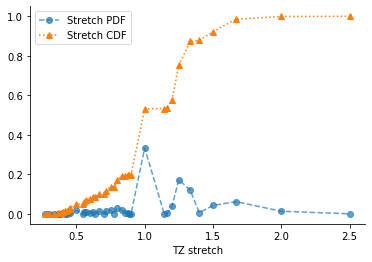

In [52]:
crunch_stretch("./simulation/data/full-stretch-2000.csv")

## Link deletion impact

An impact file contains the following columns
  - `endpoint1` The asn of the first node
  - `endpoint2` The asn of the second node
  - `degree1` The number of links (before deletion) of the 1st node
  - `degree2` The number of links (before deletion) of the 2nd node
  - `impact` The number of nodes that must send/receive updates

In [9]:
def import_impact(filename):
    df = pd.read_csv(filename, names=["endpoint1", "endpoint2", "degree1", "degree2", "impact"])
    return df

In [10]:
# Save impact to file
# link_del_impact.to_csv("./simulation/data/full-impact-2000.csv", index=False, header=False)

#### Impact by degree quotient
Here, I relate the number of updated nodes with the quotient between the maximum and the minimum degree of the endpoints  

In [15]:
def crunch_deletion_impact(filename):
    link_del_impact = import_impact(filename)
    deletion_impact = link_del_impact.to_numpy()
    print(link_del_impact)
    print("Average impact: %.3f \t Maximum impact: %.0f" % (deletion_impact[:,4].mean(), deletion_impact[:,4].max()))
    
    abs_deg_val = np.log(np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4]))
    degree_quotient_impact = np.concatenate([np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4])/np.minimum(deletion_impact[:,2:3], deletion_impact[:,3:4]).astype(float), deletion_impact[:,4:5]], axis=1)
    degree_quotient_impact = degree_quotient_impact[np.argsort(degree_quotient_impact[:,0]),:]
    degree_quotient_impact = np.array([[x[0,0], x[:,1].mean()] for x in np.split(degree_quotient_impact, np.unique(degree_quotient_impact[:,0], return_index=True)[1])[1:]])
    
    # Handle appropriately deletions without updates (y=0)
    zero_impact_quotient_idxs = degree_quotient_impact[:,1] == 0.
    zero_impact_fraction = zero_impact_quotient_idxs.sum() / float(degree_quotient_impact.shape[0])
    zero_impact_deletions = degree_quotient_impact[zero_impact_quotient_idxs, :]
    zero_impact_deletions[:,1] = 1
    degree_quotient_impact = degree_quotient_impact[degree_quotient_impact[:,1] != 0., :]
    
    print("%.2f%% of the link deletions didn't require any update" % (zero_impact_fraction*100))
    print("Average degree quotient of zero-impact deletions:\t %.3f" % (zero_impact_deletions[:,0].mean()))
    zero_impact_idxs = deletion_impact[:,4] == 0.
    print("Average maximum degree of zero-impact deletions:\t %.3f" % (np.maximum(deletion_impact[zero_impact_idxs, 2], deletion_impact[zero_impact_idxs, 3]).mean()))
    print("Average minimum degree of zero-impact deletions:\t %.3f" % (np.minimum(deletion_impact[zero_impact_idxs, 2], deletion_impact[zero_impact_idxs, 3]).mean()))
    
    
    plt.figure(figsize=(8, 6))
    plt.title("Nodes updated by degree quotient")
    plt.scatter(zero_impact_deletions[:,0], zero_impact_deletions[:,1], 60, marker='X', alpha=.1, zorder=10, label="Zero impact")
    plt.scatter(degree_quotient_impact[:,0], degree_quotient_impact[:,1], abs_deg_val * 20, alpha=.15, label="Non-zero impact")
    #plt.yscale("log")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.ylabel("AS updated")
    plt.xlabel("Quotient between degrees of endpoints");
    #plt.savefig("./figs/" + dataset_name + "-deg_quotient.svg")
    
    return degree_quotient_impact, abs_deg_val

      endpoint1  endpoint2  degree1  degree2  impact
0           174      13005     6080       51   11684
1         47321      59624      433      505       0
2         52075      34019       88     1593       0
3         12290       3741       59      745   16269
4          8426      24594      894       68       0
...         ...        ...      ...      ...     ...
2995       1273      20705      303        6    8149
2996      45194     136358       32        2     747
2997      50473     199524      506      719       0
2998      48848      49063      428      513       0
2999      47211      49120      439      430       0

[3000 rows x 5 columns]
Average impact: 2101.932 	 Maximum impact: 55330
65.78% of the link deletions didn't require any update
Average degree quotient of zero-impact deletions:	 32.002
Average maximum degree of zero-impact deletions:	 1320.113
Average minimum degree of zero-impact deletions:	 229.263


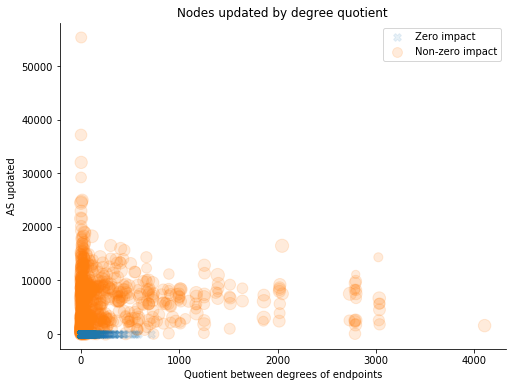

In [16]:
impact_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-GRP-3000.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0         63159       3741        2      745       2
1         30421      22773        2      543       2
2         13893        209        3     1791       3
3        263722       4323        3     1487       3
4        267708       4323        2     1486       2
...         ...        ...      ...      ...     ...
3995     132394      63956        7      804       7
3996     204263      51185        6     4270       6
3997     134626       4787        2       60       2
3998     204068      43061        2       79       2
3999      26937       6461        2     1995       2

[4000 rows x 5 columns]
Average impact: 21.908 	 Maximum impact: 13945
7.07% of the link deletions didn't require any update
Average degree quotient of zero-impact deletions:	 20.801
Average maximum degree of zero-impact deletions:	 938.600
Average minimum degree of zero-impact deletions:	 115.683


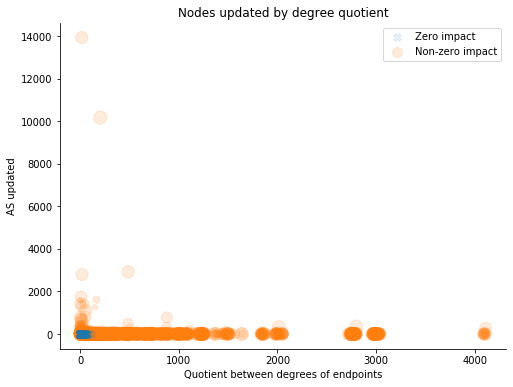

In [17]:
impact_4000 = crunch_deletion_impact("./simulation/data/full-impact-4000.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0          8647      16347      137     1508       0
1        396983       7795        2      106     773
2         31529      51088      611      454    6982
3          5466      25091      135     2430    9446
4         23106      20473     1476      591    9823
...         ...        ...      ...      ...     ...
2995       3549       7243     2187        7    8860
2996     264911      11644     1313       45       0
2997     199624      48914      448      429       0
2998      56665      43436     2208       28       0
2999      45177      55857       73        2   12768

[3000 rows x 5 columns]
Average impact: 3476.268 	 Maximum impact: 66286
43.06% of the link deletions didn't require any update
Average degree quotient of zero-impact deletions:	 10.942
Average maximum degree of zero-impact deletions:	 918.591
Average minimum degree of zero-impact deletions:	 282.368


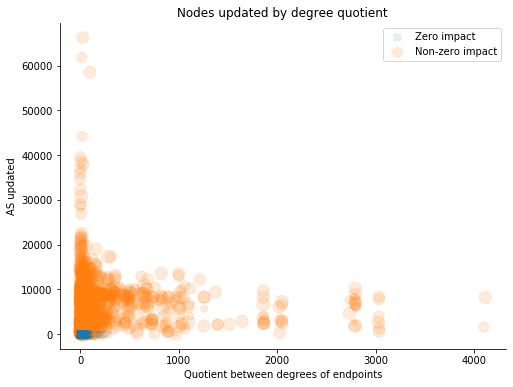

In [18]:
impact_GR_3000 = crunch_deletion_impact("./simulation/data/full-impact-GR-3000.csv")

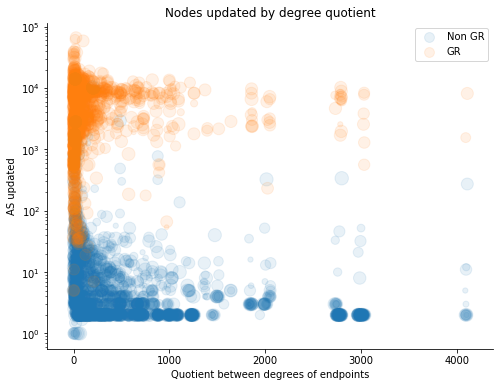

In [55]:
plt.figure(figsize=(8, 6))
plt.title("Nodes updated by degree quotient")
plt.scatter(impact_4000[0][:,0], impact_4000[0][:,1], impact_4000[1] * 20, alpha=.1, label="Non GR")
plt.scatter(impact_GR_3000[0][:,0], impact_GR_3000[0][:,1], impact_GR_3000[1] * 20, alpha=.1, label="GR")
#plt.scatter(impact_GRP_3000[0][:,0], impact_GRP_3000[0][:,1], impact_GRP_3000[1] * 20, alpha=.1, label="GRP")
plt.yscale("log")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.ylabel("AS updated")
plt.xlabel("Quotient between degrees of endpoints");
#plt.savefig("./figs/" + dataset_name + "-deg_quotient.svg")

## Link deletion stretch increase

File `full-deletion-stretch-2000.csv` was obtained restarting 3 times:
 - after 1383 links deleted
 - after 1687 links deleted

In [19]:
def import_stretch_increase(filename):
    df = pd.read_csv(filename, names=["baseline_before", "audited_before", "baseline_after", "audited_after"])
    return df

In [20]:
def crunch_stretch_increase(filename):
    pd_deletion_stretch = import_stretch_increase(filename)
    deletion_stretch = pd_deletion_stretch.to_numpy().astype(float)
    
    # Measure hops and not nodes
    deletion_stretch = deletion_stretch - 1
    
    stretch_before = deletion_stretch[:,1] / deletion_stretch[:,0]
    stretch_after = deletion_stretch[:,3] / deletion_stretch[:,2]
    
    plt.figure()
    plt.xlabel("Stretch before deletion")
    plt.ylabel("Stretch after deletion")
    plt.scatter(stretch_before, stretch_after, alpha=.4)
    
    plt.figure()
    plt.scatter(deletion_stretch[:,1], stretch_after / stretch_before, alpha=.3)
    plt.xlabel("Original TZ length")
    plt.ylabel("Stretch increase")
    plt.yscale("log")
    plt.hlines(1, xmin=1, xmax=5)
    return pd_deletion_stretch.to_numpy().astype(float)

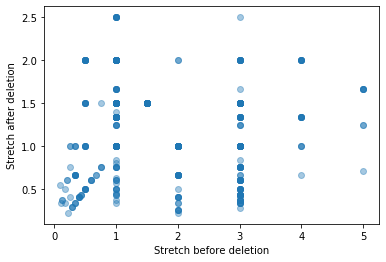

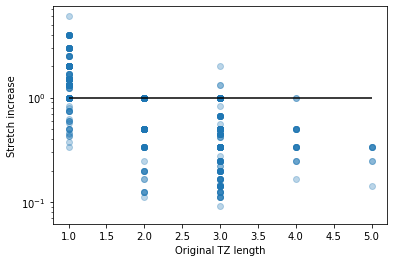

In [40]:
deletion_stretch = crunch_stretch_increase("./simulation/data/full-deletion-stretch-2000.csv")

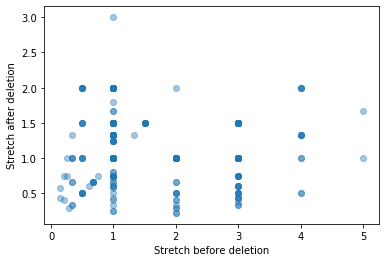

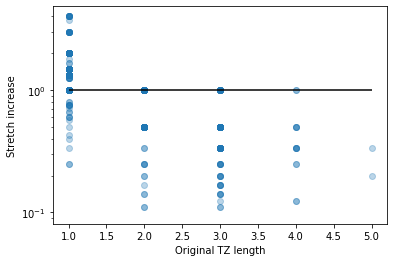

In [41]:
deletion_stretch_GR = crunch_stretch_increase("./simulation/data/full-deletion-stretch-GR-1000.csv")

In [44]:
deletion_stretch_GR[deletion_stretch_GR[:,0]>deletion_stretch_GR[:,1]]

array([[5., 3., 5., 3.],
       [6., 2., 6., 3.],
       [3., 2., 3., 4.],
       [4., 2., 4., 4.],
       [8., 2., 8., 5.],
       [5., 3., 5., 3.],
       [4., 2., 4., 4.],
       [6., 2., 5., 4.],
       [4., 2., 4., 4.],
       [3., 2., 3., 4.],
       [5., 2., 5., 4.],
       [4., 3., 4., 3.],
       [8., 3., 8., 3.],
       [6., 4., 6., 4.],
       [4., 2., 4., 3.],
       [7., 3., 7., 3.],
       [3., 2., 3., 3.],
       [3., 2., 3., 5.],
       [4., 3., 4., 3.],
       [4., 3., 4., 3.],
       [4., 3., 4., 3.],
       [3., 2., 3., 4.],
       [5., 2., 5., 5.],
       [5., 3., 5., 3.],
       [3., 2., 3., 5.],
       [7., 3., 7., 3.],
       [3., 2., 3., 5.],
       [7., 4., 7., 4.],
       [3., 2., 3., 3.],
       [4., 2., 4., 5.],
       [3., 2., 3., 4.],
       [7., 4., 7., 4.],
       [3., 2., 3., 5.],
       [3., 2., 3., 3.],
       [5., 4., 5., 4.],
       [4., 2., 4., 3.],
       [5., 3., 5., 3.],
       [3., 2., 3., 3.],
       [8., 2., 8., 4.],
       [4., 3., 4., 3.],


## Effect of multiple edge deletions on stretch

Starting from `cumulative-deletions-3x.1.csv` the first stretch measurement is performed **before** deleting any links

In [21]:
def import_cumulative_deletions(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"])
    return df

In [22]:
def stretch_statistics_by_round(round_data):
    return [(round_data[:,1]/round_data[:,0]).mean(), round_data[:,2].mean()]

In [23]:
def crunch_cumulative_deletions(filename):
    cumul_deletions = import_cumulative_deletions(filename)
    cumul_deletions = cumul_deletions.to_numpy()
    
    # Find lines that mark the beginning of a round (with the form [-round_num, -round_num, -round_num])
    cumul_by_round = np.split(cumul_deletions.astype(float), np.nonzero(np.sum(cumul_deletions, axis=1) < 1)[0])[1:]
    
    # Delete the markers
    cumul_by_round = [rd[1:] for rd in cumul_by_round]
    
    return np.array([stretch_statistics_by_round(r) for r in cumul_by_round]), cumul_by_round[0].shape[0]

In [25]:
# For each simulation, it stores ([[Stretch_by_round, With_valley_by_round] for rounds], samples_num_for_first_round)
cumulative_simulations = {
    "GRP-3x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GRP-3x.05-GCloud.csv"),
    "GR-4x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.05-GCloud-(2).csv"),
    "GR-4x.10": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.10-GCloud.csv"),
    "8x.05" :crunch_cumulative_deletions("./simulation/data/cumulative-deletions-8x.05.csv"),
    "9x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(3).csv"),
    "10x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(2).csv"),
    "12x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05.csv")
}

In [26]:
cumulative_simulations["10x.05"][0][:,0]

array([1.10776464, 1.12204944, 1.15352103, 1.15467974, 1.16002564,
       1.1736178 , 1.18352525, 1.18813442, 1.20109516, 1.19020737,
       1.19957075])

In [27]:
def calculate_x_labels(deletion_proportion, number_of_epochs):
    full_edges_num = 466982
    return [100 * deletion_proportion * (math.pow(1 - deletion_proportion, k)-1) / float(-deletion_proportion) for k in range(0, number_of_epochs)]

Text(0, 0.5, 'Average stretch')

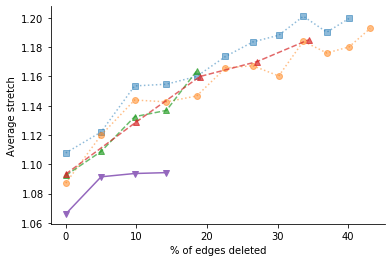

In [35]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,0], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,0], ':o', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,0], '--^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,0], '--^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,0], '-v', alpha=1, zorder=15)
plt.xlabel("% of edges deleted")
plt.ylabel("Average stretch")

Text(0, 0.5, 'Fraction of paths with valleys')

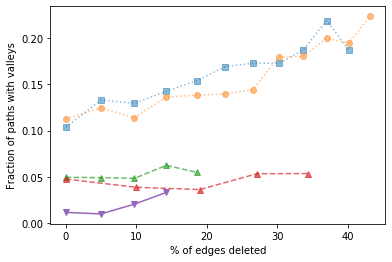

In [36]:
plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,1], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,1], ':o', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,1], '--^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,1], '--^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,1], '-v', alpha=1, zorder=15)
plt.xlabel("% of edges deleted")
plt.ylabel("Fraction of paths with valleys")